**Predicting Pathologies In X-Ray Images**
~ Paul Mooney, December 2017

The NIH Clinical Center recently released over 100,000 anonymized chest x-ray images and their corresponding data to the scientific community. The release will allow researchers across the country and around the world to freely access the datasets and increase their ability to teach computers how to detect and diagnose disease. Ultimately, this artificial intelligence mechanism can lead to clinicians making better diagnostic decisions for patients.   

https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community

http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import cv2


Load the data

In [2]:
PATH = os.path.abspath(os.path.join('..', 'input'))
SOURCE_IMAGES = os.path.join(PATH, "sample", "images")
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

images[0:10]

['/kaggle/input/sample/images/00026586_001.png',
 '/kaggle/input/sample/images/00025234_000.png',
 '/kaggle/input/sample/images/00020482_050.png',
 '/kaggle/input/sample/images/00010380_008.png',
 '/kaggle/input/sample/images/00008551_000.png',
 '/kaggle/input/sample/images/00009640_005.png',
 '/kaggle/input/sample/images/00004007_008.png',
 '/kaggle/input/sample/images/00025295_002.png',
 '/kaggle/input/sample/images/00008841_051.png',
 '/kaggle/input/sample/images/00030079_032.png']

In [3]:
labels = pd.read_csv('../input/sample_labels.csv')
labels.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,0.139
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,0.139


Plot a representative image

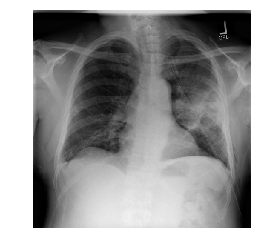

In [4]:
%matplotlib inline
image_name = "/kaggle/input/sample/images/00001256_007.png" #Image to be used as query
def plotImage(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (512,512))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotImage(image_name)

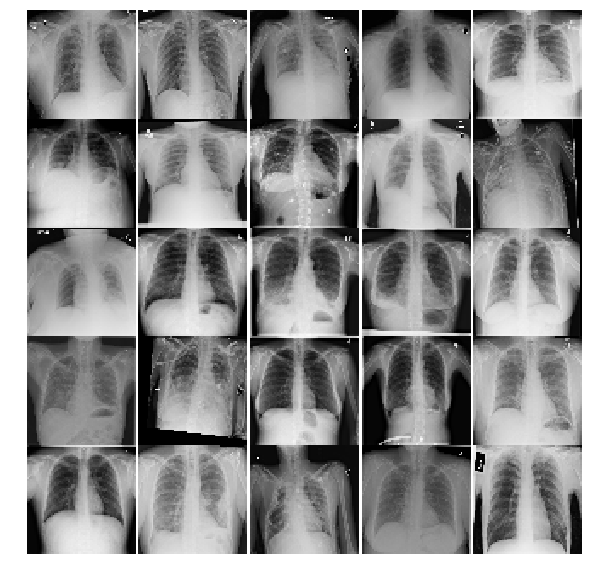

In [5]:
# Plot Multiple Images
simpsons = glob('/kaggle/input/sample/images/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in simpsons[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (64, 64)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

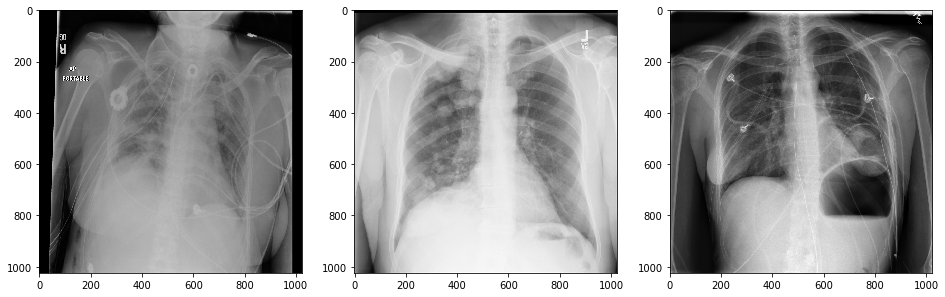

In [6]:
r = random.sample(images, 3)
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(cv2.imread(r[0]))
plt.subplot(132)
plt.imshow(cv2.imread(r[1]))
plt.subplot(133)
plt.imshow(cv2.imread(r[2])); 

What types of ailments are identified in these annotated X-ray images?

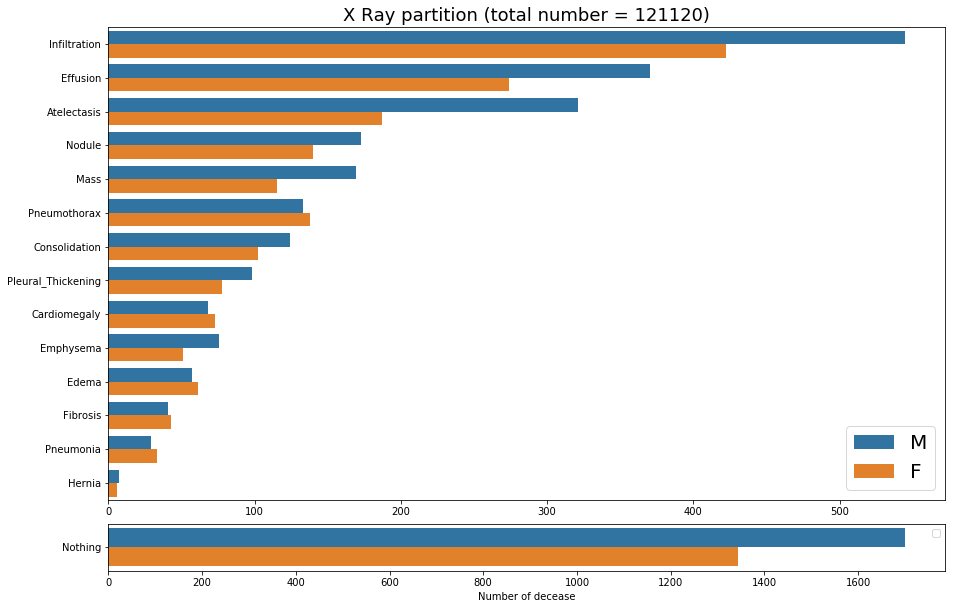

In [7]:
import matplotlib.gridspec as gridspec
import seaborn as sns


#drop unused columns
labels = labels[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]
#create new columns for each decease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
for pathology in pathology_list :
    labels[pathology] = labels['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
#remove Y after age
labels['Age']=labels['Patient Age'].apply(lambda x: x[:-1]).astype(int)

plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

labels['Nothing']=labels['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

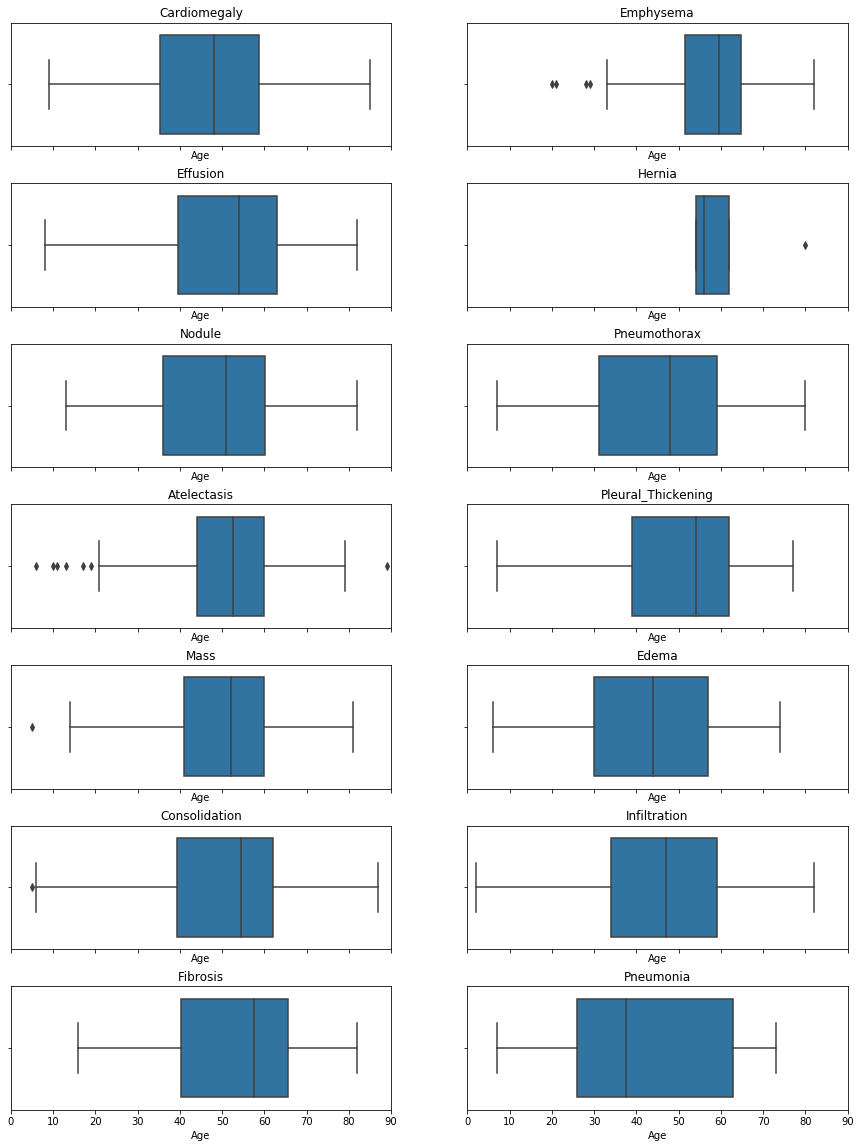

In [8]:
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))

i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    g=sns.boxplot(x='Age', hue="Patient Gender",data=labels[labels['Finding Labels']==pathology], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

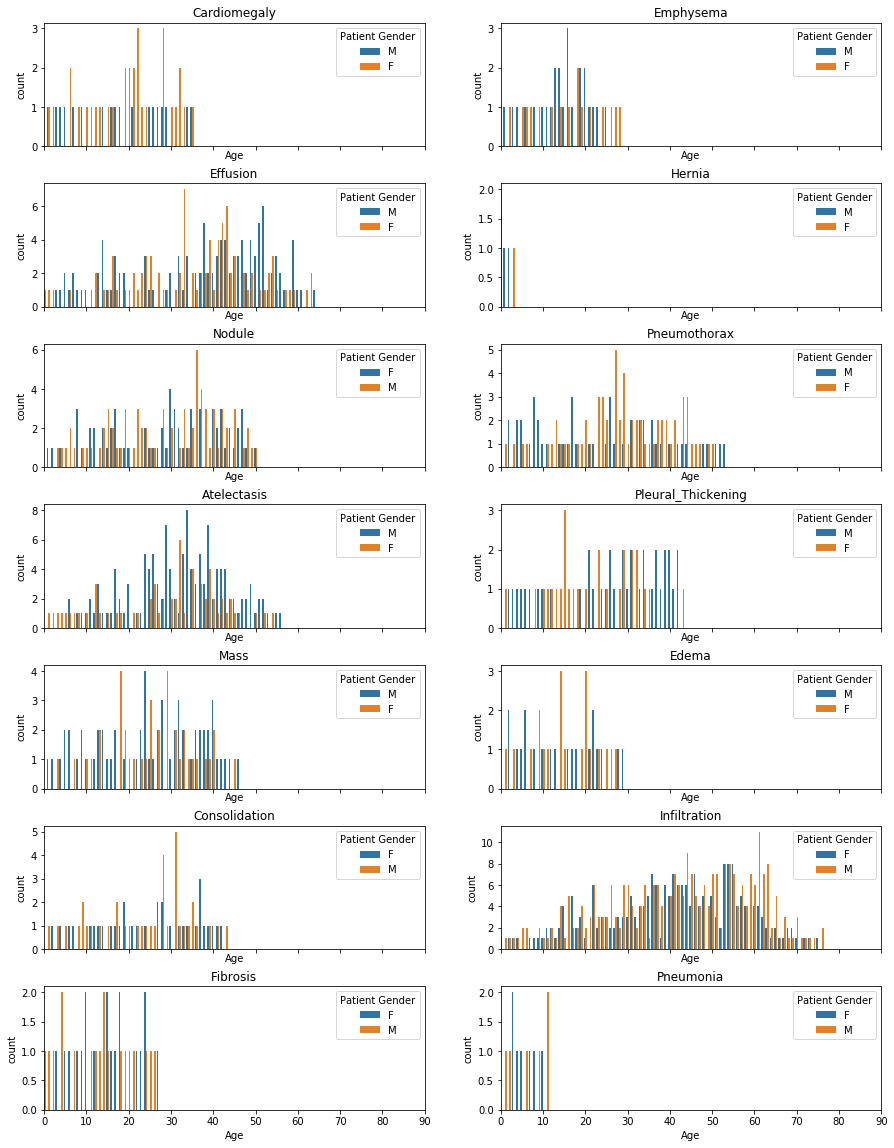

In [9]:
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))

i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    g=sns.countplot(x='Age', hue="Patient Gender",data=labels[labels['Finding Labels']==pathology], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

Convert annotated .png images into labeled numpy arrays

In [10]:
def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    NoFinding = "No Finding"
    Consolidation="Consolidation"
    Infiltration="Infiltration"
    Pneumothorax="Pneumothorax"
    Edema="Edema"
    Emphysema="Emphysema"
    Fibrosis="Fibrosis"
    Effusion="Effusion"
    Pneumonia="Pneumonia"
    Pleural_Thickening="Pleural_Thickening"
    Cardiomegaly="Cardiomegaly"
    NoduleMass="Nodule"
    Hernia="Hernia"
    Atelectasis="Atelectasis"   
    x = [] # images as arrays
    y = [] # labels Infiltration or Not_infiltration
    WIDTH = 64
    HEIGHT = 64
    for img in images:
        base = os.path.basename(img)
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]
        # Read and resize image
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        # Labels
        if NoFinding in finding:
            finding = 0
            y.append(finding)        
        elif Consolidation in finding:
            finding = 1
            y.append(finding)    
        elif Infiltration in finding:
            finding = 2
            y.append(finding)           
        elif Pneumothorax in finding:
            finding = 3
            y.append(finding)
        elif Edema in finding:
            finding = 4
            y.append(finding)
        elif Emphysema in finding:
            finding = 5
            y.append(finding)
        elif Fibrosis in finding:
            finding = 6
            y.append(finding) 
        elif Effusion in finding:
            finding = 7
            y.append(finding)             
        elif Pneumonia in finding:
            finding = 8
            y.append(finding)   
        elif Pleural_Thickening in finding:
            finding = 9
            y.append(finding) 
        elif Cardiomegaly in finding:
            finding = 10
            y.append(finding) 
        elif NoduleMass in finding:
            finding = 11
            y.append(finding) 
        elif Hernia in finding:
            finding = 12
            y.append(finding) 
        elif Atelectasis in finding:
            finding = 13
            y.append(finding) 
        else:
            finding = 14
            y.append(finding)
    return x,y

# use a for loop to shorten this function
# put variables into a dictionary

In [11]:
X,y = proc_images()
df = pd.DataFrame()
df["images"]=X
df["labels"]=y
print(len(df), df.images[0].shape)
print(type(X))

5606 (64, 64, 3)
<class 'list'>


Describe new numpy arrays

In [12]:
dict_characters = {0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 
        3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema', 6: 'Fibrosis', 7:'Effusion',
        8: 'Pneumonia', 9: 'Pleural_Thickening',10:'Cardiomegaly', 11: 'Nodule Mass', 
        12: 'Hernia', 13: 'Atelectasis'}

print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], ...      13
1  [[[11, 11, 11], [11, 11, 11], [11, 11, 11], [2...       0
2  [[[56, 56, 56], [41, 41, 41], [19, 19, 19], [1...       1
3  [[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], ...       0
4  [[[8, 8, 8], [8, 8, 8], [8, 8, 8], [7, 7, 7], ...       0
5  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      11
6  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       0
7  [[[6, 6, 6], [6, 6, 6], [6, 6, 6], [6, 6, 6], ...       5
8  [[[36, 36, 36], [35, 35, 35], [33, 33, 33], [3...      14
9  [[[8, 8, 8], [8, 8, 8], [7, 7, 7], [7, 7, 7], ...       1

{0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural_Thickening', 10: 'Cardiomegaly', 11: 'Nodule Mass', 12: 'Hernia', 13: 'Atelectasis'}


Describe the distribution of pixel intensities within a representative image

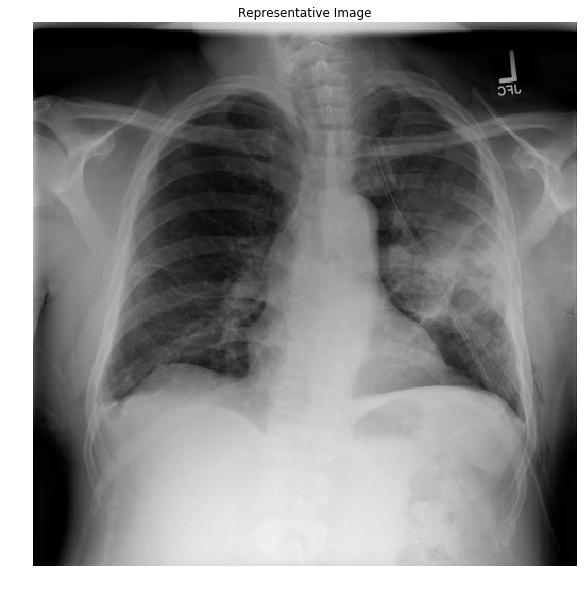

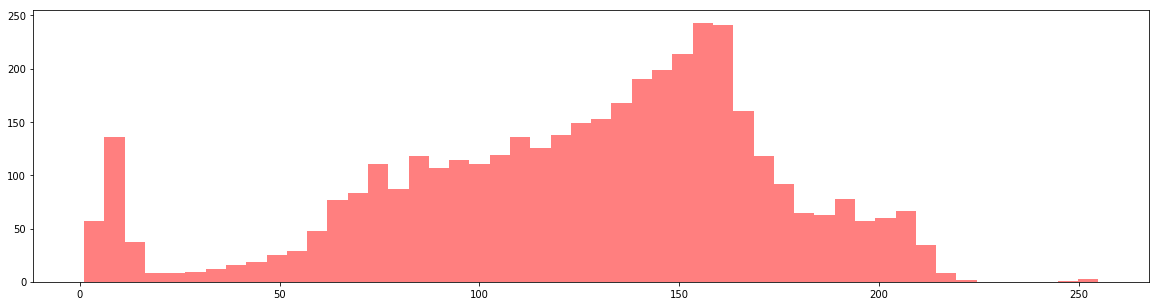

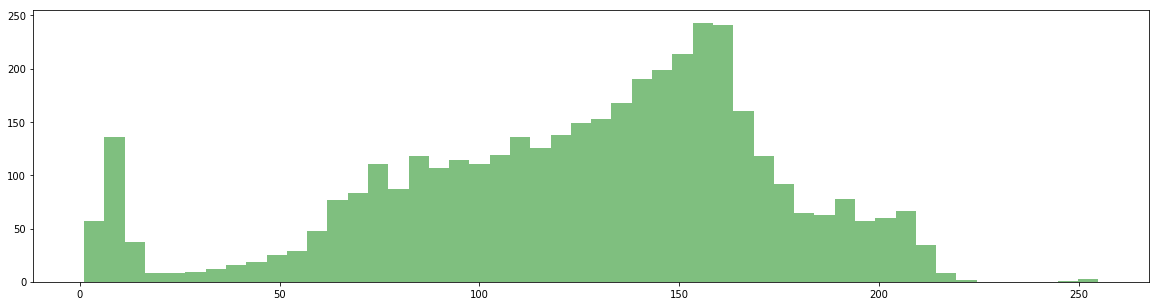

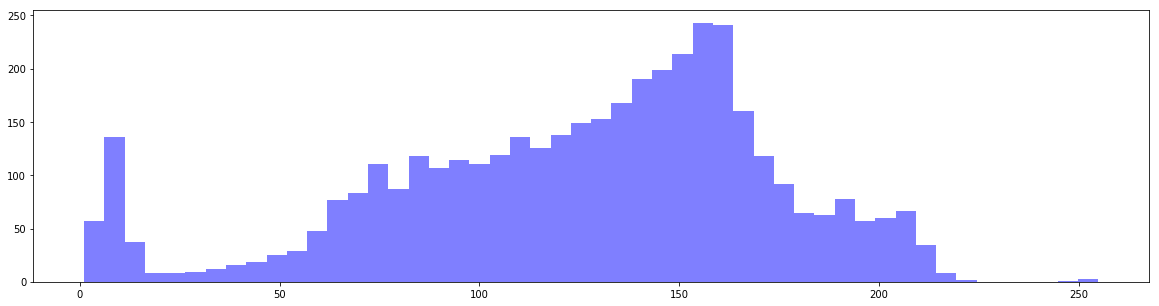

In [13]:
# We look at RGB histograms (represent colors). Histogram counts the number of pixels with a certain intensity
# between 0 and 255 for each color red, green and blue. A peak at 255 for all colors mean a lot of white ! 

i= 1 # Try 0, 1, 2.. for negative images and -1, -2, -3 for positive images and compare the histograms.
xi = X[i]


def plotArray(array):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (512,512))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotArray(xi)


# plt.imshow(xi)
# plt.axis('off')
plt.title('Representative Image')
plt.figure(figsize=(20,5))
n_bins = 50
plt.hist(xi[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.figure(figsize=(20,5))
plt.hist(xi[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
plt.figure(figsize=(20,5))
plt.hist(xi[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

Normalize the pixel intensities between zero and one.

In [14]:
X=np.array(X)
X=X/255.0

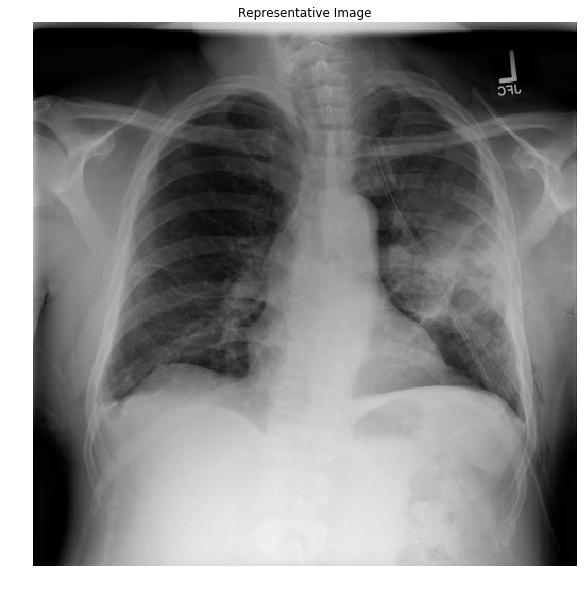

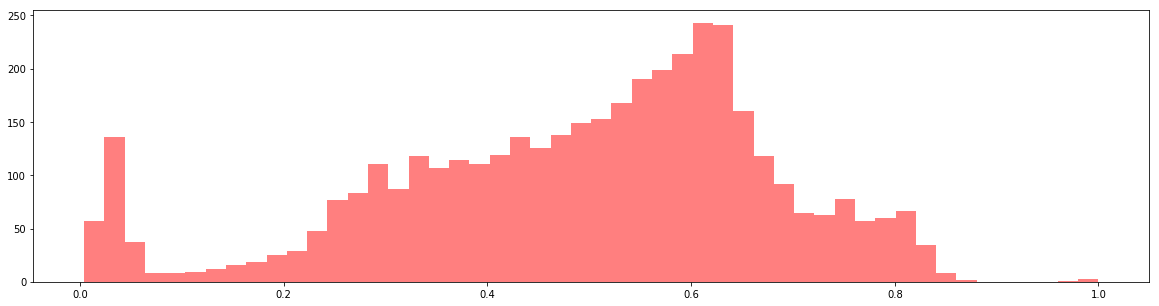

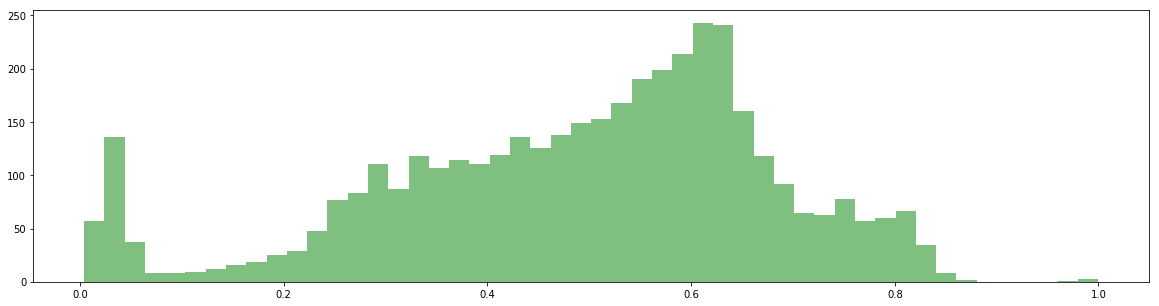

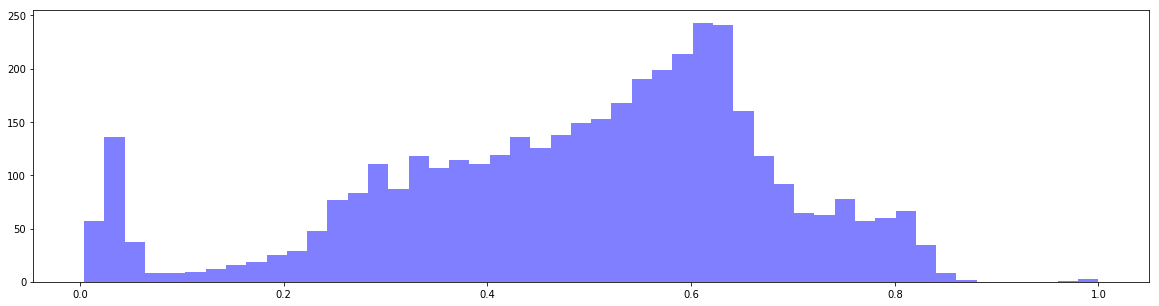

In [15]:
i= 1 # Try 0, 1, 2.. for negative images and -1, -2, -3 for positive images and compare the histograms.
xi = X[i]


def plotArray(array):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (512,512))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotArray(xi)


# plt.imshow(xi)
# plt.axis('off')
plt.title('Representative Image')
plt.figure(figsize=(20,5))
n_bins = 50
plt.hist(xi[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.figure(figsize=(20,5))
plt.hist(xi[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
plt.figure(figsize=(20,5))
plt.hist(xi[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

Describe distribution of class labels

{0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural_Thickening', 10: 'Cardiomegaly', 11: 'Nodule Mass', 12: 'Hernia', 13: 'Atelectasis'}


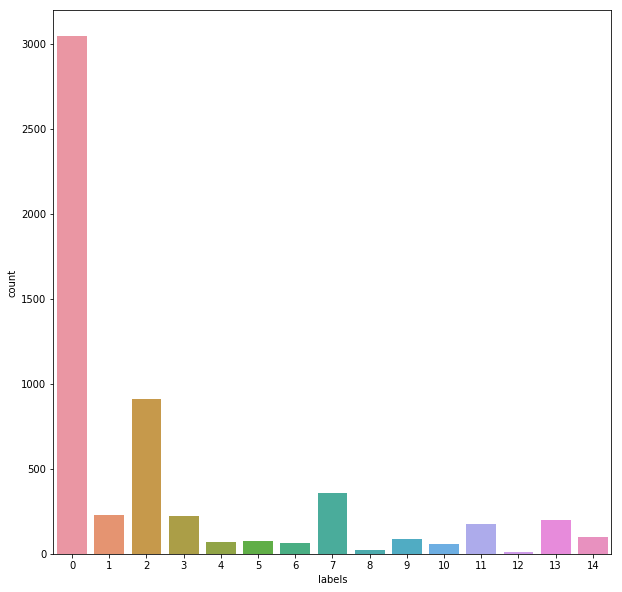

In [16]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)
#print(dist)

We have imbalanced sample sizes.  This is a problem that needs to be addressed.

But for now we can proceed with a preliminary analysis.

In [17]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import keras
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.utils import class_weight
import sklearn

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# Reduce Sample Size for DeBugging
X_train = X_train[0:5000] 
Y_train = Y_train[0:5000]
X_test = X_test[0:2000] 
Y_test = Y_test[0:2000]

In [19]:
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Data Shape:", len(X_train), X_train[0].shape)
print("Testing Data Shape:", len(X_test), X_test[0].shape)

Training Data Shape: (4484, 64, 64, 3)
Testing Data Shape: (1122, 64, 64, 3)
Training Data Shape: 4484 (64, 64, 3)
Testing Data Shape: 1122 (64, 64, 3)


Now I will try to use a CNN to predict each ailment based off of the X-Ray image.

In [20]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 20)
Y_testHot = to_categorical(Y_test, num_classes = 20)

In order to avoid having a biased model because of skewed class sizes, I will modify the class_weights parameter in order to give more weight to the rare classes.  In this case the class_weights parameter will eventually be passed to the model.fit function.

In [21]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print(class_weight)

[  0.12277705   1.65368732   0.41069597   1.69878788   5.57810945
   4.85367965   6.02795699   1.04981273  16.24927536   4.2469697
   6.79515152   2.14789272  46.71666667   1.89712352   3.77508418]


In [22]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Epoch 1/3
141/140 [==============================] - 172s 1s/step - loss: 2.9282 - acc: 0.4455 - val_loss: 1.8258 - val_acc: 0.5294
Epoch 2/3
141/140 [==============================] - 171s 1s/step - loss: 1.8932 - acc: 0.5131 - val_loss: 1.8360 - val_acc: 0.3467
Epoch 3/3
141/140 [==============================] - 168s 1s/step - loss: 1.8333 - acc: 0.5348 - val_loss: 2.0308 - val_acc: 0.5321

Keras CNN #2B - accuracy: 0.532085561497 



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 15, does not match size of target_names, 14
  .format(len(labels), len(target_names))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

        No Finding       0.54      0.99      0.70       597
     Consolidation       0.00      0.00      0.00        46
      Infiltration       0.30      0.03      0.06       188
      Pneumothorax       0.00      0.00      0.00        45
             Edema       0.00      0.00      0.00        21
         Emphysema       0.00      0.00      0.00        11
          Fibrosis       0.00      0.00      0.00        15
          Effusion       0.00      0.00      0.00        74
         Pneumonia       0.00      0.00      0.00         6
Pleural_Thickening       0.00      0.00      0.00        18
      Cardiomegaly       0.00      0.00      0.00         9
       Nodule Mass       0.00      0.00      0.00        38
            Hernia       0.00      0.00      0.00         2
       Atelectasis       0.00      0.00      0.00        30

       avg / total       0.34      0.53      0.38      1122



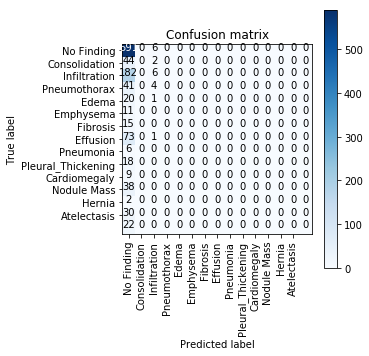

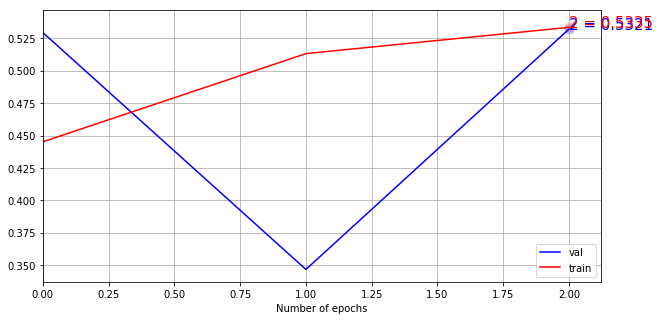

In [23]:
def runCNNconfusion(a,b,c,d):
    # In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
    batch_size = 128
    num_classes = 20
    epochs = 3
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(1024, activation = "relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = "softmax"))
    # Define the optimizer
    optimizer = RMSprop(lr=0.001, decay=1e-6)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    datagen.fit(a)
    model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, class_weight = class_weight,  validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0) 
    print('\nKeras CNN #2B - accuracy:', score[1],'\n')
    Y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(Y_pred, axis=1), target_names=list(dict_characters.values())), sep='')    
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
runCNNconfusion(X_train, Y_trainHot, X_test, Y_testHot)
plotKerasLearningCurve()

The imbalance in our dataset has resulted in a biased model.  I tried to prevent this by modifying the class_weights parameter and using in the model.fit function but apparently that was not enough.  Now I will try to compensate for the imbalanced sample size by oversampling or upsampling the minority classes.

{0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural_Thickening', 10: 'Cardiomegaly', 11: 'Nodule Mass', 12: 'Hernia', 13: 'Atelectasis'}


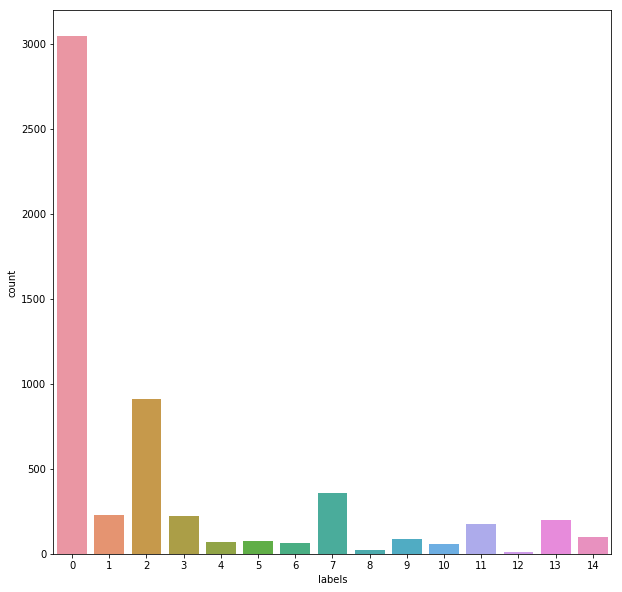

In [24]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

It is very import to do upsampling AFTER the train_test_split function otherwise you can end up with values in the testing dataset that are related to the values within the training dataset.

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# Reduce Sample Size for DeBugging
X_train = X_train[0:5000] 
Y_train = Y_train[0:5000]
X_test = X_test[0:2000] 
Y_test = Y_test[0:2000]

In [26]:
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
print("X_train Shape: ",X_train.shape)
print("X_test Shape: ",X_test.shape)
print("X_trainFlat Shape: ",X_trainFlat.shape)
print("X_testFlat Shape: ",X_testFlat.shape)

X_train Shape:  (4484, 64, 64, 3)
X_test Shape:  (1122, 64, 64, 3)
X_trainFlat Shape:  (4484, 12288)
X_testFlat Shape:  (1122, 12288)


I chose to use the RandomOverSampler upsampling strategy.  I would have preffered to use either the SMOTE or ADASYN upsampling strategies but unfortunately I had too few members of certain minority classes in order for these methods to work.

In [27]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 20)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 20)
print("X_train: ", X_train.shape)
print("X_trainFlat: ", X_trainFlat.shape)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_testRos Shape: ",X_testRos.shape)

X_train:  (4484, 64, 64, 3)
X_trainFlat:  (4484, 12288)
X_trainRos Shape:  (36495, 12288)
X_testRos Shape:  (9165, 12288)


In [28]:
for i in range(len(X_trainRos)):
    height, width, channels = 64,64,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 64,64,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
print("X_testRos Shape: ",X_testRos.shape)
print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

X_trainRos Shape:  (36495, 12288)
X_trainRosReshaped Shape:  (36495, 64, 64, 3)
X_testRos Shape:  (9165, 12288)
X_testRosReshaped Shape:  (9165, 64, 64, 3)


{0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural_Thickening', 10: 'Cardiomegaly', 11: 'Nodule Mass', 12: 'Hernia', 13: 'Atelectasis'}


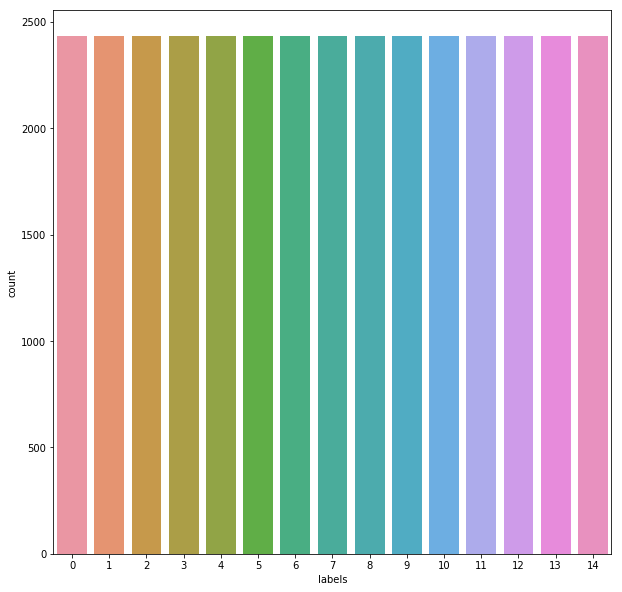

In [29]:
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

Now we have a much more even distriution of sample sizes for each of our 13 ailments (plus a 14th category for other/typos).  This should help make our model less biased in favor of the majority class (0=No Finding).

In [30]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight)

Old Class Weights:  [  0.12277705   1.65368732   0.41069597   1.69878788   5.57810945
   4.85367965   6.02795699   1.04981273  16.24927536   4.2469697
   6.79515152   2.14789272  46.71666667   1.89712352   3.77508418]
New Class Weights:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


Epoch 1/3
313/312 [==============================] - 377s 1s/step - loss: 2.3990 - acc: 0.2849 - val_loss: 2.8069 - val_acc: 0.1543
Epoch 2/3
313/312 [==============================] - 384s 1s/step - loss: 1.7849 - acc: 0.3930 - val_loss: 3.1581 - val_acc: 0.1680
Epoch 3/3
313/312 [==============================] - 388s 1s/step - loss: 1.5121 - acc: 0.5194 - val_loss: 3.2322 - val_acc: 0.1460

Keras CNN #2B - accuracy: 0.146 



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 15, does not match size of target_names, 14
  .format(len(labels), len(target_names))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

        No Finding       0.23      0.51      0.31       611
     Consolidation       0.00      0.00      0.00       611
      Infiltration       0.28      0.09      0.14       611
      Pneumothorax       0.00      0.00      0.00        58
             Edema       0.00      0.00      0.00        16
         Emphysema       0.00      0.00      0.00        10
          Fibrosis       0.00      0.00      0.00        17
          Effusion       0.00      0.00      0.00       365
         Pneumonia       0.00      0.00      0.00         8
Pleural_Thickening       0.00      0.00      0.00        20
      Cardiomegaly       0.00      0.00      0.00         7
       Nodule Mass       0.14      0.09      0.11       611
            Hernia       0.00      0.00      0.00         1
       Atelectasis       0.01      0.38      0.03        32

       avg / total       0.13      0.15      0.12      3000



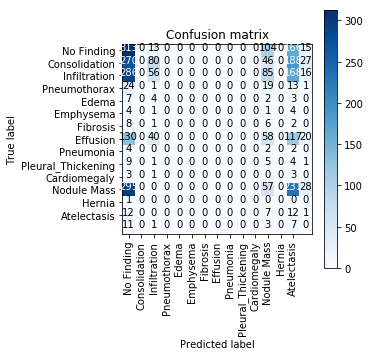

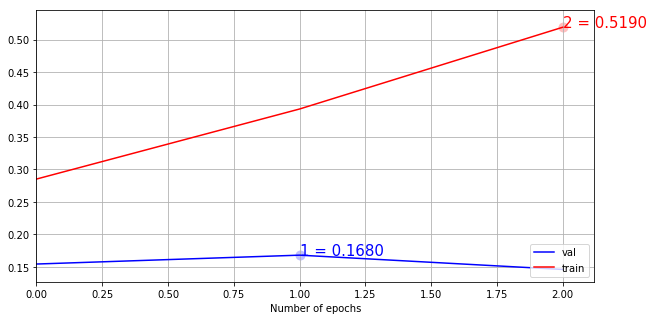

In [31]:
runCNNconfusion(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:3000], Y_testRosHot[:3000])
plotKerasLearningCurve()

Hmm... it looks like our model is still biased... I thought that was going to work...

Previously I mentioned that it is important to do the upsampling/oversampling/data augmentation step AFTER the train_test_split function so that you can avoid accidentally getting testing data that is related to your training data.  If you do the upsampling BEFORE the train_test_split you will end up with a model that overfits the training data badly, as demonstrated below.

In [32]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
newweights = class_weight*8
print(newweights)

[   0.98221638   13.22949853    3.28556777   13.59030303   44.62487562
   38.82943723   48.22365591    8.39850187  129.9942029    33.97575758
   54.36121212   17.18314176  373.73333333   15.17698816   30.2006734 ]


In [33]:
def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    NoFinding = "No Finding"
    Consolidation="Consolidation"
    Infiltration="Infiltration"
    Pneumothorax="Pneumothorax"
    Edema="Edema"
    Emphysema="Emphysema"
    Fibrosis="Fibrosis"
    Effusion="Effusion"
    Pneumonia="Pneumonia"
    Pleural_Thickening="Pleural_Thickening"
    Cardiomegaly="Cardiomegaly"
    NoduleMass="Nodule"
    Hernia="Hernia"
    Atelectasis="Atelectasis"
    
    x = [] # images as arrays
    y = [] # labels Infiltration or Not_infiltration
    WIDTH = 64
    HEIGHT = 64

    for img in images:
        base = os.path.basename(img)
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]

        # Read and resize image
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
#1,13,3,13,44,39,48,8,129,33,54,17,374,15,30
        # Labels
        if NoFinding in finding:
            finding = 0
            y.append(finding)
        elif Consolidation in finding:
            finding = 1
            y.append(finding) 
            for i in range(13):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Infiltration in finding:
            finding = 2
            y.append(finding)
            for i in range(3):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Pneumothorax in finding:
            finding = 3
            y.append(finding)
            for i in range(13):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Edema in finding:
            finding = 4
            y.append(finding)
            for i in range(44):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Emphysema in finding:
            finding = 5
            y.append(finding)
            for i in range(39):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Fibrosis in finding:
            finding = 6
            y.append(finding) 
            for i in range(48):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Effusion in finding:
            finding = 7
            y.append(finding) 
            for i in range(8):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Pneumonia in finding:
            finding = 8
            y.append(finding)
            for i in range(129):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Pleural_Thickening in finding:
            finding = 9
            y.append(finding) 
            for i in range(33):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Cardiomegaly in finding:
            finding = 10
            y.append(finding) 
            for i in range(54):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif NoduleMass in finding:
            finding = 11
            y.append(finding) 
            for i in range(15):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Hernia in finding:
            finding = 12
            y.append(finding) 
            for i in range(374):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        elif Atelectasis in finding:
            finding = 13
            y.append(finding) 
            for i in range(14):
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                y.append(finding)
        else:
            finding = 14
            y.append(finding)
    return x,y

In [34]:
X = []
y = []

In [35]:
X2,y2 = proc_images()
dfNew = pd.DataFrame()
dfNew["images"]=X2
dfNew["labels"]=y2
X2=np.array(X2)
X2=X2/255.0
print(len(dfNew), dfNew.images[0].shape)

43110 (64, 64, 3)


{0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural_Thickening', 10: 'Cardiomegaly', 11: 'Nodule Mass', 12: 'Hernia', 13: 'Atelectasis'}


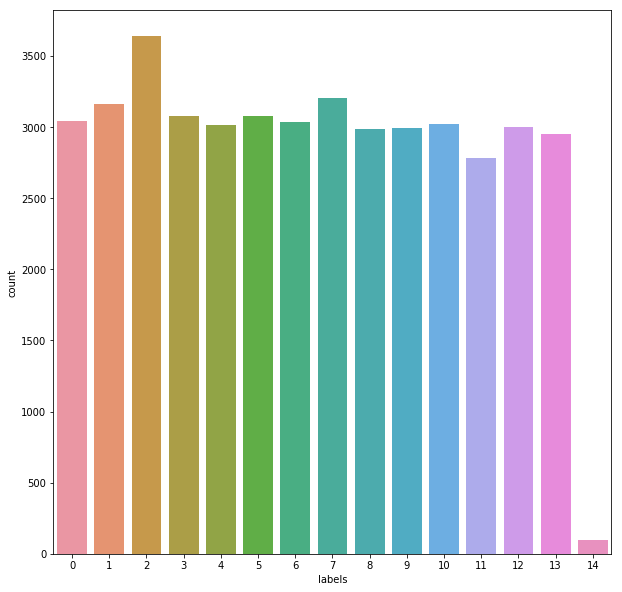

In [36]:
newLab = dfNew['labels']
newImg = dfNew['images']
dist = newLab.value_counts()
sns.countplot(newLab)
print(dict_characters)
#print(dist)

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X2, y2, test_size=0.2)
# Reduce Sample Size for DeBugging
X_train = X_train[0:20000] 
Y_train = Y_train[0:20000]
X_test = X_test[0:5000] 
Y_test = Y_test[0:5000]

In [38]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 20)
Y_testHot = to_categorical(Y_test, num_classes = 20)
print(X_train.shape)

(20000, 64, 64, 3)


In [39]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y2), y2)
print(class_weight)

[  0.94415243   0.90834387   0.78956044   0.93311688   0.95323383
   0.93311688   0.94601712   0.89700375   0.96120401   0.9605615
   0.95008264   1.03232759   0.958        0.97258883  29.03030303]


Epoch 1/3
625/625 [==============================] - 773s 1s/step - loss: 2.4546 - acc: 0.2512 - val_loss: 1.5979 - val_acc: 0.4966
Epoch 2/3
625/625 [==============================] - 770s 1s/step - loss: 1.3802 - acc: 0.5571 - val_loss: 0.8882 - val_acc: 0.7256
Epoch 3/3
625/625 [==============================] - 769s 1s/step - loss: 0.8702 - acc: 0.7201 - val_loss: 0.5497 - val_acc: 0.8158

Keras CNN #2B - accuracy: 0.8158 



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 15, does not match size of target_names, 14
  .format(len(labels), len(target_names))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

        No Finding       0.36      0.35      0.35       352
     Consolidation       0.76      0.84      0.80       347
      Infiltration       0.58      0.41      0.48       421
      Pneumothorax       0.89      0.80      0.84       375
             Edema       0.95      1.00      0.97       346
         Emphysema       0.97      1.00      0.99       376
          Fibrosis       0.86      0.98      0.92       366
          Effusion       0.64      0.72      0.68       378
         Pneumonia       1.00      1.00      1.00       329
Pleural_Thickening       0.98      0.90      0.94       341
      Cardiomegaly       0.96      0.94      0.95       357
       Nodule Mass       0.63      0.86      0.73       325
            Hernia       1.00      1.00      1.00       343
       Atelectasis       0.89      0.71      0.79       336

       avg / total       0.82      0.82      0.81      5000



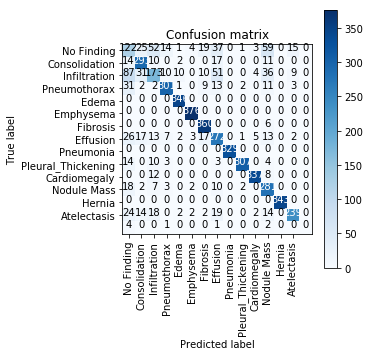

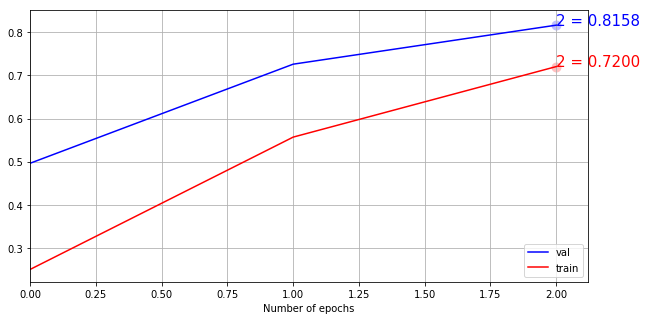

In [40]:
runCNNconfusion(X_train, Y_trainHot, X_test, Y_testHot)
plotKerasLearningCurve()

To improve these predictions, try using the full and uncompressed dataset while running the code on a more powerful machine with an increased number of epochs.

To Do: 
1) Decide on optimal NN parameters and architecture
2) Decide on optimal data augmentation parameters
3) Work with the larger dataset and try downsampling the majority class
4) Try additional solutions for dealing with imbalanced datasets
5) Plot representative images of each pathology
6) Try combining minority classes

In [41]:
# print(dict_characters)
# def displayDataTwo(input):
#     """
#     Displays arrays with labels
#     """
#     height, width, channels = 64,64,3
#     figure,image = plt.subplots(2,10, figsize=(10,10))
#     for i in range(20):
#         image[i].imshow(X_trainFlat[i].reshape((height,width,channels)))
#         image[i].axis('off')
#         image[i].set_title(y[i])

# displayDataTwo(X_trainFlat)

In [42]:
# n = 100

# mask = np.hstack([np.random.choice(np.where(Y_train == l)[0], n, replace=False)
#                       for l in np.unique(Y_train)])
